In [1]:
import numpy as np
import pandas as pd

from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline

# Load functions

In [64]:
def plot_recovery_overview(df,
                           parameters=['v', 'gamma', 's', 'tau'],
                           parameter_ticks=dict(v=np.linspace(0, 0.00015, 3),
                                                gamma=np.linspace(-1, 1, 3),
                                                s=np.linspace(0, 0.015, 3),
                                                tau=np.linspace(0, 2, 3)),
                           markersize=54,
                           successcolor='green',
                           failcolor='red',
                           linewidth=1.5,
                           hpd_color='darkgray',):

    n = len(df)

    fig, axs = plt.subplots(1, len(parameters),
                            figsize=(n / 10, len(parameters * 4)),
                            sharey=True)

    for p, parameter in enumerate(parameters):

        success = ((df[parameter + '_gen'] > df[parameter + '_rec_hpd_lower']) &
                   (df[parameter + '_gen'] < df[parameter + '_rec_hpd_upper'])).values.astype(int)
        color = np.array([failcolor, successcolor])[success]

        # Generating values
        axs[p].scatter(df[parameter + '_gen'],
                       np.arange(n),
                       marker='.',
                       color='black',
                       s=markersize,
                       zorder=2,
                       alpha=0.5)
        # Recovered values
        #  Mode
        axs[p].scatter(df[parameter + '_rec'],
                       np.arange(n),
                       marker='o',
                       facecolor='white',
                       linewidth=linewidth,
                       color=color,
                       s=markersize,
                       zorder=1)
        #  HPD
        axs[p].hlines(y=np.arange(n),
                      xmin=df[parameter + '_rec_hpd_lower'],
                      xmax=df[parameter + '_rec_hpd_upper'],
                      linewidth=linewidth,
                      color=color,
                      zorder=0)

        # Ticks and axes
        for spine in ['top', 'right']:
            axs[p].spines[spine].set_visible(False)
        axs[p].set_xticks(parameter_ticks[parameter])
        axs[p].set_xlim(parameter_ticks[parameter][0],
                        parameter_ticks[parameter][-1])

        axs[p].set_ylim(0, n)
        axs[p].set_yticks([])
        axs[p].set_title(parameter)

    fig.tight_layout()

    return fig, axs


In [187]:
def plot_recovery_boxplot(df, parameters=['v', 'gamma', 's', 'tau'],
                          levels=['low', 'medium', 'high'],
                          linewidth=2, linecolor='lightgray', markersize=25,
                          markerlinecolor='black', markerfacecolor='white',
                          marker='o', alpha=0.5, width=0.6,
                          parameter_limits=None,
                          parameter_jitter=None):

    # Default values
    if parameter_limits is None:
        parameter_limits = dict(v=[0, 0.00018],
                                gamma=[-1.3, 1.3],
                                s=[0.002, 0.012],
                                tau=[-0.1, 1.5])

    fig, axs = plt.subplots(1, len(parameters),
                            figsize=(len(parameters) * 3, 3))

    for p, parameter in enumerate(parameters):
        data = np.array([df.loc[df[parameter + '_level'] == level, parameter + '_rec']
                         for level in levels]).T

        n = data.shape[0]
        if parameter_jitter is None:
            parameter_jitter = dict(v=np.random.normal(loc=0, scale=0.00001, size=n),
                                    gamma=np.random.normal(loc=0, scale=0.2, size=n),
                                    s=np.random.normal(loc=0, scale=0.0003, size=n),
                                    tau=np.random.normal(loc=0, scale=0.05, size=n))

        axs[p].boxplot(data, widths=width)

        yticks = [df.loc[df[parameter + '_level'] == level, parameter + '_gen'].values.mean()
                  for level in levels]

        for value in yticks:
            axs[p].axhline(y=value, alpha=0.1, zorder=-
                           1, color='black', linewidth=1)

        # Ticks and Axes
        axs[p].set_xticks(np.arange(1, len(levels) + 1))
        axs[p].set_yticks(yticks)
        axs[p].set_xticklabels(levels)
        axs[p].set_yticklabels(levels, rotation=90, va='center')
        axs[p].set_xlim(1 - width,
                        len(levels) + width)
        axs[p].set_xlabel('Generating')
        axs[p].set_ylabel('Recovered')
        axs[p].set_title(parameter)
        for spine in ['top', 'right']:
            axs[p].spines[spine].set_visible(False)

    fig.tight_layout(w_pad=2.5)

    return fig, axs

# Visualization

In [207]:
methods = ['advi', 'metropolis', 'de-metropolis']
remove_nonconverged = False

for method in methods:
    print('Loading results from hierarchical parameter recovery using {}...'.format(method))
    parameter_recovery = pd.read_csv(join('results',
                                          'parameter-recovery_hierarchical',
                                           method,
                                          'parameter-recovery_hierarchical_{}.csv'.format(method)),
                                     index_col=0)
    
    print('P(converged):', parameter_recovery['converged'].mean())
    if remove_nonconverged:
        print('Removing results from non-converged estimation attempts...')
        parameter_recovery = parameter_recovery[parameter_recovery['converged'] != False].copy()
        
    plot_recovery_overview(df=parameter_recovery)
    plt.savefig(join('results',
                     'parameter-recovery_hierarchical',
                      method,
                     'parameter-recovery_hierarchical_{}_overview.png'.format(method)),
                dpi=300)
    plt.close()

    plot_recovery_boxplot(df=parameter_recovery)
    plt.savefig(join('results',
                     'parameter-recovery_hierarchical',
                      method,
                     'parameter-recovery_hierarchical_{}_boxplot.png'.format(method)),
                dpi=300)
    plt.close()

Loading results from hierarchical parameter recovery using advi...
P(converged): nan
Loading results from hierarchical parameter recovery using metropolis...
P(converged): 0.09523809523809523
Loading results from hierarchical parameter recovery using de-metropolis...
P(converged): 0.0


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice.
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [192]:
parameter_recovery.head()

,index,v_level,gamma_level,s_level,tau_level,v_gen,gamma_gen,s_gen,tau_gen,v_rec,...,gamma_rec,gamma_rec_hpd_lower,gamma_rec_hpd_upper,s_rec,s_rec_hpd_lower,s_rec_hpd_upper,tau_rec,tau_rec_hpd_lower,tau_rec_hpd_upper,converged
0,0,low,low,low,low,0.000029,-0.8,0.0047,0.215,0.000043,...,-0.710486,-0.778796,-0.634538,0.004012,0.003238,0.004791,0.269164,0.195979,0.343410,NaN
1,1,low,low,low,medium,0.000029,-0.8,0.0047,0.675,0.000042,...,-0.681435,-0.761512,-0.596965,0.004066,0.003321,0.004849,0.597708,0.478845,0.726235,NaN
2,2,low,low,low,high,0.000029,-0.8,0.0047,1.135,0.000044,...,-0.645627,-0.697761,-0.595190,0.004384,0.003823,0.004939,1.078838,0.844027,1.349474,NaN
3,3,low,low,medium,low,0.000029,-0.8,0.0075,0.215,0.000041,...,-0.655883,-0.749638,-0.563759,0.007241,0.006422,0.008099,0.309479,0.222082,0.401476,NaN
4,4,low,low,medium,medium,0.000029,-0.8,0.0075,0.675,0.000039,...,-0.681048,-0.763486,-0.607040,0.007712,0.007206,0.008178,0.730538,0.598107,0.884502,NaN


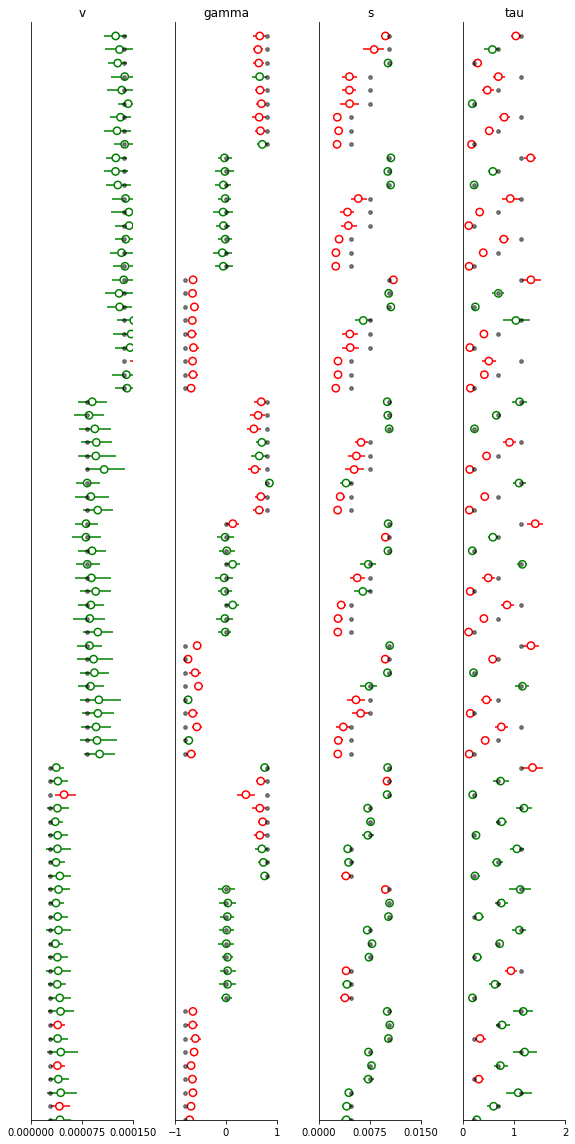

In [66]:
plot_recovery_overview(parameter_recovery);

(<Figure size 864x216 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11974d898>,
       dtype=object))

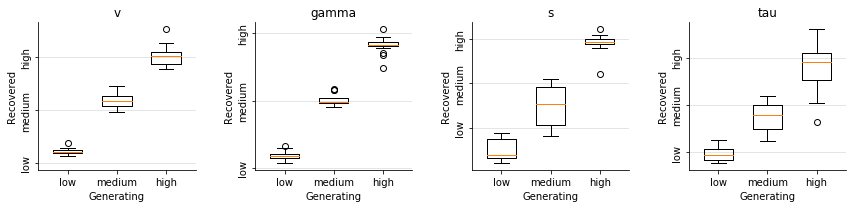

In [196]:
plot_recovery_boxplot(parameter_recovery)